![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

### Package Version
- tensorflow==2.3.0
- plotly==4.4.1
- pandas==1.0.5
- matplotlib==3.2.2

# Fruit Classification using Transfer Learning
- This notebook is a brief application of transfer learning on the Fruits-360 dataset.
- We will be comparing the Transfer learning approach to the regular approach.

## Transfer Learning

In transfer learning, we first train a base network on a base dataset and task, and then we repurpose the learned features, or transfer them, to a second target network to be trained on a target dataset and task. This process will tend to work if the features are general, meaning suitable to both base and target tasks, instead of specific to the base task.

Lisa Torrey and Jude Shavlik in their chapter on transfer learning describe three possible benefits to look for when using transfer learning:

- Higher start. The initial skill (before refining the model) on the source model is higher than it otherwise would be.
- Higher slope. The rate of improvement of skill during training of the source model is steeper than it otherwise would be.
- Higher asymptote. The converged skill of the trained model is better than it otherwise would be.

<center><img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/09/Three-ways-in-which-transfer-might-improve-learning.png"></center>

Basically, we take a pre-trained model (the weights and parameters of a network that has been trained on a large dataset by somebody else) and “fine-tune” the model with our own dataset. The idea is that this pre-trained model will either provide the initialized weights leading to a faster convergence or it will act as a fixed feature extractor for the task of interest.

These two major transfer learning scenarios look as follows:

1. Finetuning the convnet: Instead of random initializaion, we initialize the network with a pretrained network, like the one that has been trained on a large dataset like imagenet 1000. Rest of the training looks as usual. In this scenario the entire network needs to be retrained on the dataset of our interest
2. ConvNet as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In this notebook we will demonstrate the first scenario.


## Dataset

**Fruits 360 dataset: A dataset of images containing fruits and vegetables**
- Version: 2020.05.18.0

### Content
#### The following fruits are included
Apples (different varieties: Crimson Snow, Golden, Golden-Red, Granny Smith, Pink Lady, Red, Red Delicious), Apricot, Avocado, Avocado ripe, Banana (Yellow, Red, Lady Finger), Beetroot Red, Blueberry, Cactus fruit, Cantaloupe (2 varieties), Carambula, Cauliflower, Cherry (different varieties, Rainier), Cherry Wax (Yellow, Red, Black), Chestnut, Clementine, Cocos, Corn (with husk), Cucumber (ripened), Dates, Eggplant, Fig, Ginger Root, Granadilla, Grape (Blue, Pink, White (different varieties)), Grapefruit (Pink, White), Guava, Hazelnut, Huckleberry, Kiwi, Kaki, Kohlrabi, Kumsquats, Lemon (normal, Meyer), Lime, Lychee, Mandarine, Mango (Green, Red), Mangostan, Maracuja, Melon Piel de Sapo, Mulberry, Nectarine (Regular, Flat), Nut (Forest, Pecan), Onion (Red, White), Orange, Papaya, Passion fruit, Peach (different varieties), Pepino, Pear (different varieties, Abate, Forelle, Kaiser, Monster, Red, Stone, Williams), Pepper (Red, Green, Orange, Yellow), Physalis (normal, with Husk), Pineapple (normal, Mini), Pitahaya Red, Plum (different varieties), Pomegranate, Pomelo Sweetie, Potato (Red, Sweet, White), Quince, Rambutan, Raspberry, Redcurrant, Salak, Strawberry (normal, Wedge), Tamarillo, Tangelo, Tomato (different varieties, Maroon, Cherry Red, Yellow, not ripened, Heart), Walnut, Watermelon.

#### Dataset properties
- Total number of images: 90483.
- Training set size: 67692 images (one fruit or vegetable per image).
- Test set size: 22688 images (one fruit or vegetable per image).
- Multi-fruits set size: 103 images (more than one fruit (or fruit class) per image)
- Number of classes: 131 (fruits and vegetables).
- Image size: 100x100 pixels.
- Filename format: imageindex100.jpg (e.g. 32100.jpg) or rimageindex100.jpg (e.g. r32100.jpg) or r2imageindex100.jpg or r3imageindex100.jpg. "r" stands for rotated fruit. "r2" means that the fruit was rotated around the 3rd axis. "100" comes from image size (100x100 pixels).
- Different varieties of the same fruit (apple for instance) are stored as belonging to different classes.

### Load the data

Read the zip file `fruits.zip` and extract it's contents

In [1]:
from zipfile import ZipFile
ZipFile("/content/drive/My Drive/Fruit_Classification/fruits.zip", 'r').extractall()

Like the rest of `tensorflow.keras`, the image augmentation API is simple and powerful. We will use the **ImageDataGenerator** to fetch data and feed it to our network

`tensorflow.keras` provides the **ImageDataGenerator** class that defines the configuration for image data preparation and augmentation. Rather than performing the operations on your entire image dataset in memory, the API is designed to be iterated by the deep learning model fitting process, creating augmented image data for you just-in-time. This reduces your memory overhead, but adds some additional time cost during model training.

The data generator itself is in fact an iterator, returning batches of image samples from the directory when requested. We can configure the batch size and prepare the data generator and get batches of images by calling the **flow_from_directory()** function.

### Initialize ImageDataGenerator
- Train data generator
  - Rescale the images
  - Specify shear Intensity
  - Specify range for random zoom
  - Randomly flip inputs horizontally
- Test data generator
  - Rescale the images

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

### Define variables
- Set value for image height as required by ResNet-50
- Set value for image width as required by ResNet-50
- Set path to train and test directory in variables

In [3]:
img_rows = 224
img_cols = 224

train_data_dir_path = '/content/fruits-360/Training'
test_data_dir_path = '/content/fruits-360/Test'

### Get training & testing data from ImageDataGenerator
- Give directory path
- Give target size
- Give batch_size
- Specify classes, to use less number of classes we need to give class names in a list (we are using less classes to reduce the execution time)
- Specify class_mode
- Specify color_mode

You can get details here
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [4]:
training_set = train_datagen.flow_from_directory(train_data_dir_path, 
                                            target_size = (img_rows, img_cols), 
                                            batch_size = 32,
                                            classes = ['Apple Red 1', 'Apricot', 'Avocado', 'Banana', 'Beetroot', 'Blueberry', 
                                                       'Cactus fruit', 'Cantaloupe 1', 'Carambula', 'Cauliflower', 'Cherry 1', 
                                                       'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Cucumber Ripe', 'Dates', 'Eggplant', 
                                                       'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Guava', 'Hazelnut', 
                                                       'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer'],
                                            class_mode='categorical',
                                            color_mode='rgb')

testing_set = test_datagen.flow_from_directory(test_data_dir_path, 
                                            target_size = (img_rows, img_cols), 
                                            batch_size = 32,
                                            classes = ['Apple Red 1', 'Apricot', 'Avocado', 'Banana', 'Beetroot', 'Blueberry', 
                                                       'Cactus fruit', 'Cantaloupe 1', 'Carambula', 'Cauliflower', 'Cherry 1', 
                                                       'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Cucumber Ripe', 'Dates', 'Eggplant', 
                                                       'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Guava', 'Hazelnut', 
                                                       'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer'],
                                            class_mode='categorical',
                                            color_mode='rgb')

Found 15525 images belonging to 31 classes.
Found 5213 images belonging to 31 classes.


#### Let's check class mappings

In [5]:
training_set.class_indices

{'Apple Red 1': 0,
 'Apricot': 1,
 'Avocado': 2,
 'Banana': 3,
 'Beetroot': 4,
 'Blueberry': 5,
 'Cactus fruit': 6,
 'Cantaloupe 1': 7,
 'Carambula': 8,
 'Cauliflower': 9,
 'Cherry 1': 10,
 'Chestnut': 11,
 'Clementine': 12,
 'Cocos': 13,
 'Corn': 14,
 'Cucumber Ripe': 15,
 'Dates': 16,
 'Eggplant': 17,
 'Fig': 18,
 'Ginger Root': 19,
 'Granadilla': 20,
 'Grape Blue': 21,
 'Guava': 22,
 'Hazelnut': 23,
 'Huckleberry': 24,
 'Kaki': 25,
 'Kiwi': 26,
 'Kohlrabi': 27,
 'Kumquats': 28,
 'Lemon': 29,
 'Lemon Meyer': 30}

## Visualising the data

In [6]:
import pandas as pd

training_data = pd.DataFrame(training_set.classes, columns=['classes'])
testing_data = pd.DataFrame(testing_set.classes, columns=['classes'])

In [7]:
def create_stack_bar_data(col, df):
    aggregated = df[col].value_counts().sort_index()
    x_values = aggregated.index.tolist()
    y_values = aggregated.values.tolist()
    return x_values, y_values

In [8]:
from plotly.offline import iplot
import plotly.graph_objs as go

x1, y1 = create_stack_bar_data('classes', training_data)
x1 = list(training_set.class_indices.keys())

trace1 = go.Bar(x=x1, y=y1, opacity=0.75, name="Class Count")
layout = dict(height=400, width=1200, title='Class Distribution in Training Data', legend=dict(orientation="h"), 
                yaxis = dict(title = 'Class Count'))
fig = go.Figure(data=[trace1], layout=layout)
iplot(fig)

In [9]:
x1, y1 = create_stack_bar_data('classes', testing_data)
x1 = list(testing_set.class_indices.keys())

trace1 = go.Bar(x=x1, y=y1, opacity=0.75, name="Class Count")
layout = dict(height=400, width=1200, title='Class Distribution in Testing Data', legend=dict(orientation="h"), 
                yaxis = dict(title = 'Class Count'))
fig = go.Figure(data=[trace1], layout=layout)
iplot(fig)

As we can see, all the classes are well-balanced in training as well as in the testing

## Building and compiling model

### Building Pretrained Model
- Here, we load the ResNet-50 with the ImageNet weights.
- We remove the top so that we can add our own layer according to the number of our classes.
- We then add our own layers to complete the model architecture.

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

resnet_base = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = resnet_base.output
x = GlobalAveragePooling2D()(x)

# add a fully-connected layer
x = Dense(512, activation='relu')(x)

# and a fully connected output/classification layer
predictions = Dense(31, activation='softmax')(x)

# create the full network so we can train on it
resnet_pretrained = Model(inputs=resnet_base.input, outputs=predictions)

94773248/94765736 [==============================] - 1s 0us/step


### Building the Vanilla Model

In [11]:
resnet_base_vanilla = ResNet50(weights=None, include_top=False)

# add a global spatial average pooling layer
x = resnet_base_vanilla.output
x = GlobalAveragePooling2D()(x)

# add a fully-connected layer
x = Dense(512, activation='relu')(x)

# and a fully connected output/classification layer
predictions = Dense(31, activation='softmax')(x)

# create the full network so we can train on it
resnet_vanilla = Model(inputs=resnet_base_vanilla.input, outputs=predictions)

### Compiling the Models
Set the loss function, the optimization algorithm to be used and metrics to be calculated at the end of each epoch.

In [12]:
from tensorflow.keras.optimizers import SGD

resnet_pretrained.compile(loss='categorical_crossentropy',
                                optimizer=SGD(lr=1e-4, momentum=0.9),
                                metrics=['accuracy'])

resnet_vanilla.compile(loss='categorical_crossentropy',
                             optimizer=SGD(lr=1e-4, momentum=0.9),
                             metrics=['accuracy'])

## Fitting the models

In [13]:
history_resnet_pretrained = resnet_pretrained.fit(training_set,
                                                  epochs=5,
                                                  verbose = 1,
                                                  validation_data = testing_set)

Epoch 1/5
486/486 [==============================] - 234s 481ms/step - loss: 1.2612 - accuracy: 0.7780 - val_loss: 3.4552 - val_accuracy: 0.0340
Epoch 2/5
486/486 [==============================] - 231s 476ms/step - loss: 0.1146 - accuracy: 0.9977 - val_loss: 0.8489 - val_accuracy: 0.7667
Epoch 3/5
486/486 [==============================] - 232s 478ms/step - loss: 0.0490 - accuracy: 0.9983 - val_loss: 0.0904 - val_accuracy: 0.9800
Epoch 4/5
486/486 [==============================] - 236s 486ms/step - loss: 0.0291 - accuracy: 0.9991 - val_loss: 0.0845 - val_accuracy: 0.9806
Epoch 5/5
486/486 [==============================] - 236s 485ms/step - loss: 0.0205 - accuracy: 0.9992 - val_loss: 0.0756 - val_accuracy: 0.9824


In [14]:
history_resnet_vanilla = resnet_vanilla.fit(training_set,
                                            epochs=5,
                                            verbose = 1,
                                            validation_data = testing_set)

Epoch 1/5
486/486 [==============================] - 239s 492ms/step - loss: 2.6813 - accuracy: 0.2555 - val_loss: 2.0353 - val_accuracy: 0.4840
Epoch 2/5
486/486 [==============================] - 238s 489ms/step - loss: 1.3325 - accuracy: 0.6600 - val_loss: 0.8873 - val_accuracy: 0.7840
Epoch 3/5
486/486 [==============================] - 239s 493ms/step - loss: 0.6216 - accuracy: 0.8429 - val_loss: 0.4001 - val_accuracy: 0.8926
Epoch 4/5
486/486 [==============================] - 239s 492ms/step - loss: 0.3465 - accuracy: 0.9125 - val_loss: 0.2983 - val_accuracy: 0.8947
Epoch 5/5
486/486 [==============================] - 239s 492ms/step - loss: 0.2326 - accuracy: 0.9442 - val_loss: 0.2341 - val_accuracy: 0.9290


## Compare the models by plots

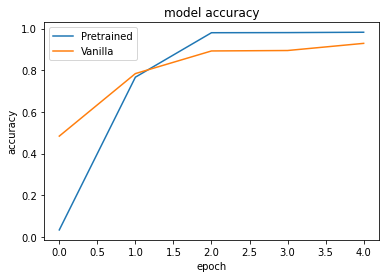

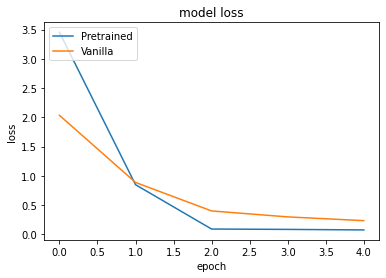

In [16]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history_resnet_pretrained.history['val_accuracy'])
plt.plot(history_resnet_vanilla.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Pretrained', 'Vanilla'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_resnet_pretrained.history['val_loss'])
plt.plot(history_resnet_vanilla.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Pretrained', 'Vanilla'], loc='upper left')
plt.show()